In [369]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform
from ott.geometry.costs import SqEuclidean

In [370]:
def C_row_upper(T, q, mu, p_max): # upper bound
    t = T * q
    mu = np.minimum(mu, p_max) # scale to either remain the same or push to bound
    T = t * np.divide(mu[:,None], np.sum(t, axis=1, keepdims=True))
    q = np.divide(t, T, out=np.ones_like(T), where=(T != 0.0)) # adjust for zeros in the plan
    return T, q, mu

def C_row_lower(T, q, mu, p_min): # lower bound
    t = T * q
    mu = np.maximum(mu, p_min) # scale to either remain the same or push to bound
    T = t * np.divide(mu[:,None], np.sum(t, axis=1, keepdims=True))
    q = np.divide(t, T, out=np.ones_like(T), where=(T != 0.0)) # adjust for zeros in the plan
    return T, q, mu

def C_col_upper(T, q, nu, p_max): # upper bound
    t = T * q
    nu = np.minimum(nu, p_max) # scale to either remain the same or push to bound
    T = t * np.divide(nu[None,:], np.sum(t, axis=0, keepdims=True))
    q = np.divide(t, T, out=np.ones_like(T), where=(T != 0.0))
    return T, q, nu

def C_col_lower(T, q, nu, p_min): # lower bound
    t = T * q
    nu = np.maximum(nu, p_min) # scale to either remain the same or push to bound
    T = t * np.divide(nu[None,:], np.sum(t, axis=0, keepdims=True))
    q = np.divide(t, T, out=np.ones_like(T), where=(T != 0.0))
    return T, q, nu


In [371]:
gamma_0 = 0.5 # regularisation
gamma_c = 10.0 # column constraints
gamma_r = 10.0 # row constraints

num_a = 150
num_b = 250
num_iters = int(5e2)

In [372]:
# locs
a = np.arange(num_a)
b = np.arange(num_b)

# weights 
mu = np.ones_like(a, dtype=np.float64)
# mu /= np.sum(mu)
mu_0 = mu.copy()

nu = np.ones_like(b, dtype=np.float64)
# nu /= np.sum(nu)
nu_0 = nu.copy()

# classes
a_cls = np.random.choice(6, size=(num_a,), p=[0.15, 0.15, 0.2, 0.2, 0.1, 0.2])
b_cls = np.random.choice(6, size=(num_b,), p=[0.1, 0.2, 0.05, 0.1, 0.05, 0.5])

# costs
C = 5 * np.random.random(size=(num_a, num_b)) + 5 * (a_cls[:,None] != b_cls[None,:])
K = np.pow(np.e, -C / gamma_0)

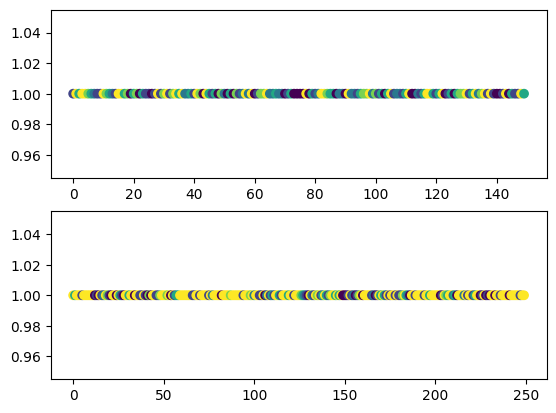

In [373]:
fig, axs = plt.subplots(2)

axs[0].scatter(a, mu, c=a_cls)
axs[1].scatter(b, nu, c=b_cls)

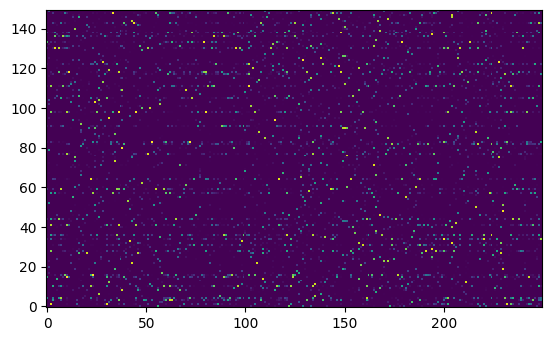

In [374]:
# constraints
rows_to_relax = np.where(a_cls == np.max(a_cls))[0]
m_ub, m_lb = mu.copy(), mu.copy()
m_ub[a_cls != np.max(a_cls)] = mu[a_cls != np.max(a_cls)] * (num_a / (num_a - rows_to_relax.shape[0]))
m_lb[rows_to_relax] = 1e-10

cols_to_relax = np.where(b_cls == np.max(b_cls))[0]
n_ub, n_lb = nu.copy(), nu.copy()
n_ub[b_cls != np.max(b_cls)] = nu[b_cls != np.max(b_cls)] * (num_b / (num_b - cols_to_relax.shape[0]))
n_lb[cols_to_relax] = 1e-10

blocked_correspondences = {0: [4], 1: [3], 2: [], 3: [], 4: [1, 2]}
for i, row in enumerate(K):
    if i in rows_to_relax: continue # if class is unknown, no zero blocks

    for j, col in enumerate(row):
        if j in cols_to_relax: continue # if class is unknown, no zero blocks

        elif int(b_cls[j]) in blocked_correspondences[int(a_cls[i])]:
            K[i,j] = 0.0

ax = plt.gca()
ax.pcolormesh(b, a, K)
ax.set_aspect('equal', 'box')

# TO-DOs:

- modify division by t such that we don't get nans for lb=0.0

558.1337182184751


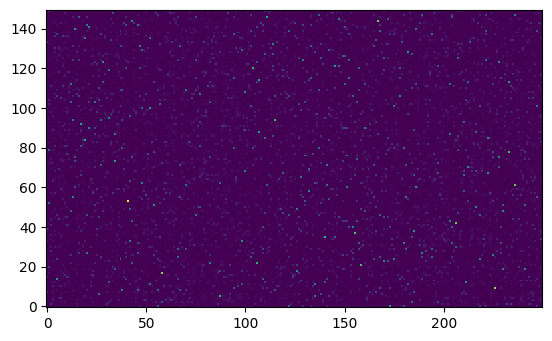

In [375]:
T = K.copy()
T_old = T.copy()
convergence_list = np.zeros(shape=(num_iters))

q0 = np.ones_like(K)
q1 = np.ones_like(K)
q2 = np.ones_like(K)
q3 = np.ones_like(K)

for i in range(num_iters):
    # row constraints
    T, q0, mu = C_row_upper(T, q0, mu, m_ub) # ub
    T, q1, mu = C_row_lower(T, q1, mu, m_lb) # lb

    # col constraints
    T, q2, nu = C_col_upper(T, q2, nu, n_ub) # ub
    T, q3, nu = C_col_lower(T, q3, nu, n_lb) # lb

    convergence_list[i] = np.linalg.norm((T - T_old).ravel(), ord=1)
    T_old = T.copy()

ax = plt.gca()
ax.pcolormesh(b, a, T)
ax.set_aspect('equal', 'box')
print(np.sum(np.multiply(T, C)))

Text(0, 0.5, 'Change in T')

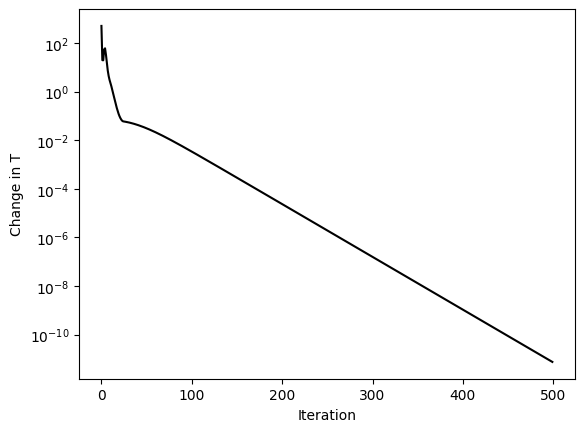

In [376]:
fig, ax = plt.subplots()

ax.plot(convergence_list, c='k')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Change in T')

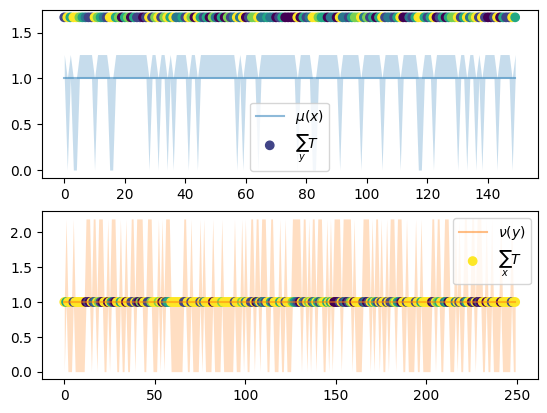

In [383]:
fig, axs = plt.subplots(2)

axs[0].plot(a, mu_0, label=r'$\mu(x)$', c='tab:blue', alpha=0.5)
# axs[0].plot(a, m_ub, c='tab:blue', alpha=0.5, linestyle='dashed')
# axs[0].plot(a, m_lb, c='tab:blue', alpha=0.5, linestyle='dashed')
axs[0].fill_between(a, m_ub, m_lb, alpha=0.25, color='tab:blue', lw=0)

axs[1].plot(b, nu_0, label=r'$\nu(y)$', c='tab:orange', alpha=0.5)
axs[1].fill_between(b, n_ub, n_lb, alpha=0.25, color='tab:orange', lw=0)

axs[0].scatter(a, np.sum(T, axis=1), label=r'$\sum_y  T$', c=a_cls)
axs[1].scatter(b, np.sum(T, axis=0), label=r'$\sum_x  T$', c=b_cls)

axs[0].legend()
axs[1].legend()

In [385]:
np.minimum(mu, m_ub)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [384]:
np.minimum(np.sum(T, axis=1), m_ub)

array([1.2605042, 1.       , 1.2605042, 1.       , 1.       , 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.       , 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.       , 1.       , 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.       , 1.2605042,
       1.2605042, 1.       , 1.2605042, 1.2605042, 1.       , 1.2605042,
       1.       , 1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.       ,
       1.2605042, 1.2605042, 1.       , 1.2605042, 1.2605042, 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.       , 1.2605042, 1.       ,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.       , 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.2605042,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.2605042, 1.       ,
       1.2605042, 1.2605042, 1.2605042, 1.2605042, 

In [382]:
# T, q0, mu = C_row_upper(T, q0, mu, m_ub) # ub
# T, q1, mu = C_row_lower(T, q1, mu, m_lb) # lb

# # col constraints
# T, q2, nu = C_col_upper(T, q2, nu, n_ub) # ub
T, q3, nu = C_col_lower(T, q3, nu, n_lb) # lb